In [1]:
from IPython.display import IFrame, display, HTML

import pandas as pd
import numpy as np

from bokeh.models import ColumnDataSource, Plot, Circle, Range1d, LinearAxis, TapTool, HoverTool, Text
from bokeh.embed import file_html
from bokeh.plotting import vplot
from bokeh.resources import INLINE
from bokeh.models.actions import Callback
from bokeh.models.widgets import Slider

### Get the Data

In [2]:
# Links via http://www.gapminder.org/data/ 

population_url = "http://spreadsheets.google.com/pub?key=phAwcNAVuyj0XOoBL_n5tAQ&output=xls"
fertility_url = "http://spreadsheets.google.com/pub?key=phAwcNAVuyj0TAlJeCEzcGQ&output=xls"
life_expectancy_url = "http://spreadsheets.google.com/pub?key=tiAiXcrneZrUnnJ9dBU-PAw&output=xls"

def get_data(url):
    # Get the data from the url and return only 1962 - 2013
    df = pd.read_excel(url, index_col=0)
    df = df.unstack().unstack()
    df = df[(df.index >= 1962) & (df.index <= 2013)]
    df = df.unstack().unstack()    
    return df

fertility_df = get_data(fertility_url)
life_expectancy_df = get_data(life_expectancy_url)
population_df = get_data(population_url)

In [3]:
# have common countries across all data
fertility_df = fertility_df.drop(fertility_df.index.difference(life_expectancy_df.index))
population_df = population_df.drop(population_df.index.difference(life_expectancy_df.index))

# get a size value based on population, but don't let it get too small
population_df_size = np.sqrt(population_df/np.pi)/200
min_size = 3
population_df_size = population_df_size.where(population_df_size >= min_size).fillna(min_size)

### Build an html plot

In [4]:
sources = {}

for i, country in enumerate(fertility_df.index):
    fertility = fertility_df.loc[country]
    fertility.name = 'fertility'
    life = life_expectancy_df.loc[country]
    life.name = 'life' 
    population = population_df_size.loc[country]
    population.name = 'population' 
    new_df = pd.concat([fertility, life, population], axis=1)
    new_df['country'] = country
    sources['_' + str(i)] = ColumnDataSource(new_df)
    
years = list(fertility_df.columns)

xdr = Range1d(1, 8)
ydr = Range1d(20, 85)
plot = Plot(
    x_range=xdr,
    y_range=ydr,
    title="",
    plot_width=800,
    plot_height=400,
    outline_line_color=None,
    toolbar_location=None,
)
xaxis = LinearAxis()
yaxis = LinearAxis()   
plot.add_layout(xaxis, 'left')
plot.add_layout(yaxis, 'below')
tooltips = "@index<br />@country"
plot.add_tools(HoverTool(tooltips=tooltips))
default_selection = {
        '0d': {'flag': False, 'indices': []},
        '1d': {'indices': [0]},
        '2d': {'indices': []}
    }

for source in sources.values():
    source.selected = default_selection
    empty_circle = Circle(x='fertility', y='life', fill_color=None, line_color=None, size='population')
    red_circle = Circle(x='fertility', y='life', fill_color='#F6931F', line_color='#995a13', size='population')
    plot.add_glyph(source, empty_circle, selection_glyph=red_circle, nonselection_glyph=empty_circle)

javascript_list_of_sources = str(list(sources.keys())).replace("'", "")

    
code = """
    var years = %s;
    var new_selection = years.indexOf(slider.get('value'));
    var new_selection_object = {'indices': [new_selection]};
    var sources = %s;

    sources.forEach(function(s) {
        s.attributes.selected['1d'] = new_selection_object;
        s.trigger('change');
    });
""" % (years, javascript_list_of_sources)


callback = Callback(args=sources, code=code)
slider = Slider(start=1962, end=2013, value=1, step=1, title="Year", callback=callback)
callback.args["slider"] = slider

layout = vplot(plot, slider)
html = file_html(layout, INLINE, "gapminder")

## Play along with Hans

In [5]:
IFrame(src="https://www.youtube.com/embed/hVimVzgtD6w?t=3m57s", width=420, height=315)

For the impatient, skip to 3m 58s. Otherwise enjoy a great example of statistics communication.


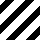
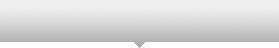
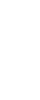
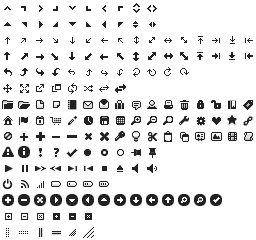
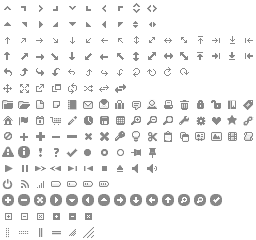
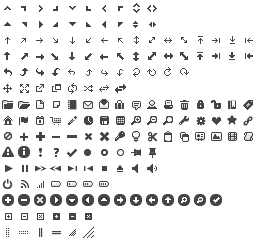
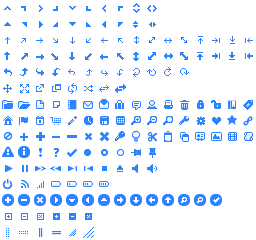
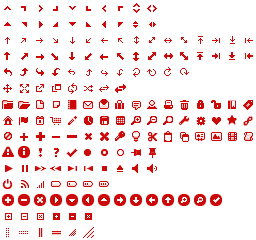
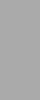
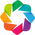
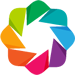
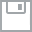
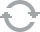
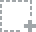
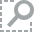
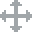
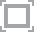
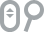

In [6]:
display(HTML(html))